# Static Polymer Devolatilization

## Introduction

Solution, melt, and bulk polymerization processes often include a _physical_ devolatilization (DV) step. In polycondensations, DV occurs alongside polymerization, as removing the condensate is essential for building up the polymer molecular weight. In solution and bulk polymerizations, DV takes place immediately after polymerization to recover the solvent and unreacted monomers, and eliminate [VOC]s. DV can be carried out with _static_ or _rotating_ equipment. In this notebook, we focus on the first type of DV process, using the devolatilization of polystyrene (Sulzer) as an example.

<p align="center">
  <img src="../assets/devo_flowsheet_streams.png" width="800" alt="Static devolatilization.">
</p>

This process consists of two stages. The first is a classic flash operation, where the polymer solution is preheated under pressure to maintain its liquid state, then allowed to vaporize in a large-diameter vessel. The second stage builds on this principle but uses a stripping agent (e.g., water) to promote bubble formation in the melt and reduce the partial pressure of the solvent (see note 1) in the gas phase. Both effects enhance the mass-transfer rate under the high-viscosity conditions present in the second stage.

A static DV stage is usually modeled on the assumption of phase equilibrium. Deviations from this ideal behavior are typically addressed by introducing an empirical efficiency factor (as in conventional distillation), rather than explicitly accounting for mass-transfer limitations. For a given stage, the material balances are:

$$ F = L + V $$
$$ F w_{i,F} = L w_{i,L} + V w_{i,V} $$

where $F$, $L$, and $V$ represent the feed, liquid, and vapor mass flow rates, respectively, and $w_{i,X}$ denotes the mass fraction of component $i$ in stream $X$. For all volatile species, the vapor-liquid equilibrium (VLE) condition is:

$$ P y_i = a_i(w_{i,L}, T) P^*_i(T) $$

where $P$ is the total pressure, $T$ is the flash temperature, $y_i$ is the mole fraction of component $i$ in the vapor phase (related to $w_{i,V}$), $P^*_i$ is the pure-component vapor pressure of $i$, and $a_i$ is the thermodynamic activity of $i$ in the liquid phase. This particular form of the vapor-liquid equilibrium (VLE) condition applies only up to moderate pressures, but that is often an excellent approximation, except in certain high-pressure polyolefin applications. 

The activity of the volatile species in the liquid phase can be estimated with the help of a suitable activity coefficient model or equation of state. A popular choice is the Flory-Huggins activity model, which for a binary solution reads:

$$ a_S = w_S \exp\left[ \left(1 - \frac{1}{DP} \right) (1 - w_S) + \chi (1 - w_S)^2 \right] $$

where $w_S$ is the mass fraction of the volatile species (called solvent), $DP$ is the degree of polymerization of the polymer, and $\chi$ is the solvent-polymer interaction parameter. Generalizations of this equation are available for [multicomponent] mixtures.

The final equation, which relates the amount of volatiles vaporized to the degree of superheating of the feed, is given by the energy balance:

$$ F \sum_i w_{i,F} \bar{c}_{P,i} (T_F - T) = V \sum_i w_{i,V} \Delta_{vap} H_i (T) $$

where $T_F$ is the feed inlet temperature.


**Notes:**
1. In polymer solution thermodynamics terminology, the volatile species is often referred to as the _solvent_, regardless of its chemical function in the process. For example, in a solution of styrene and polystyrene, styrene may be referred to as the solvent, even though it is actually a monomer.
2. In binary polymer solutions, the solvent and the polymer are typically assigned the indices 1 and 2, respectively. However, we will avoid using this convention to prevent confusion, especially since Python arrays are 0-based.

[VOC]: https://en.wikipedia.org/wiki/Volatile_organic_compound
[multicomponent]: https://hugomvale.github.io/polykin/reference/thermo/acm/FloryHuggins_activity/

## Numerical Solution

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root_scalar

### Model Parameters

Let's begin by gathering all the model parameters. All values are taken from [Schmidt & Ray (1981)].

[Schmidt & Ray (1981)]: https://doi.org/10.1016/0009-2509(81)80174-1

In [1]:
def dippr_101(T: float, A: float, B: float, C: float, D: float, E: float) -> float:
    """DIPPR equation 101.

    Parameters
    ----------
    T : float
        Temperature (K).
    A : float
        Parameter.
    B : float
        Parameter.
    C : float
        Parameter.
    D : float
        Parameter.
    E : float
        Parameter.

    Returns
    -------
    float
        Property value.
    """
    return np.exp(A + B/T + C*np.log(T) + D*T**E)

In [2]:
def Psat(T: float, name: str) -> float:
    """Vapor pressure of a pure component.

    Parameters
    ----------
    T : float
        Temperature (°C).
    name : str
        Component name.

    Returns
    -------
    float
        Vapor pressure (bar).
    """

    if name == 'styrene':
        A = 1.0593e2
        B = -8.6859e3
        C = -1.2420e1
        D = 7.5583e-6
        E = 2.0
    elif name == 'water':
        A = 7.3649e1
        B = -7.2582e3
        C = -7.3037e0
        D = 4.1653e-6
        E = 2.0
    else:
        ValueError(f"Unknown component: {name}")

    return 1e-5*dippr_101(T + 273.15, A, B, C, D, E)

In [5]:
def activity_flory_huggins(w_S: float | np.ndarray,chi: float, DP: float
                           ) -> float | np.ndarray:
    """Flory-Huggins activity model for a binary solution.

    Parameters
    ----------
    w_S : float
        Solvent mass fraction.
    chi : float
        Interaction parameter.
    DP : float
        Degree of polymerization.

    Returns
    -------
    float | np.ndarray
        Solvent activity.
    """
    w_P = 1 - w_S
    return w_S*np.exp((1 - 1/DP)*w_P + chi*w_P**2)

In [7]:
params = {
    'solvent': 'styrene',
    'inert': 'water',
    'chi': 0.35,
    'DP': 1e3,
    'DHvap': {
        'styrene': 0.0,
        'water': 0.0
    },
    'cp': {
        'styrene': 2e3,
        'water': 4.1e3,
        'polymer': 2e3
    }
}

## Equilibrium Analysis

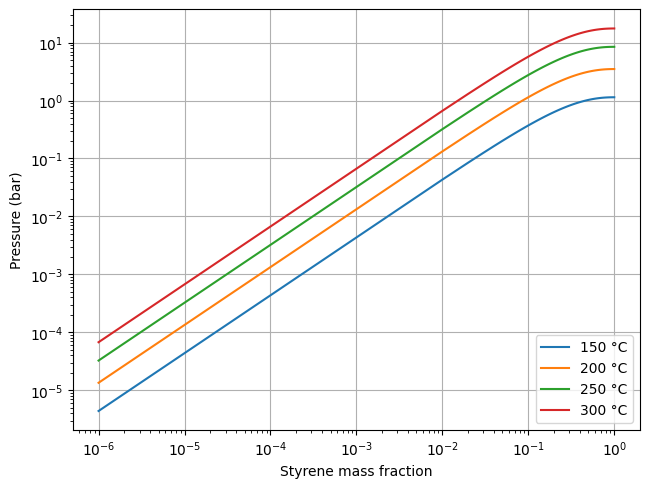

In [8]:
fig, ax = plt.subplots()
fig.tight_layout()

ax.set_xlabel("Styrene mass fraction")
ax.set_xscale('log')
w_S = np.linspace(1e-6, 1., num=101)

# Saturation pressure
ax.set_ylabel("Pressure (bar)")
ax.set_yscale('log')
P_S = np.empty_like(w_S)
for t in [150., 200., 250., 300.]:
    a_S = activity_flory_huggins(w_S, params['chi'], params['DP'])
    P_S = a_S*Psat(t, 'styrene')
    ax.plot(w_S, P_S, label=f"{t:.0f} °C")

ax.legend(loc='lower right')
ax.grid(True) 

## Binary System

In [ ]:
def flash_HP(F, wF_S, TF, P, params):

    def flash(alpha_V):
        V = alpha_V*F
        L = F - V
        wL_S = (F*wF_S - V) / L

        DHvap = params['DHvap']
        cp = params['cp']
        T = TF - (V/F)*DHvap/cp
        a_S = activity_flory_huggins(wL_S, params['chi'], params['DP']) 
        Ps = Psat(T, params['solvent'])

The gel effect is already quite significant for mixtures with 50 wt% monomer. In contrast, the glass effect only becomes significant under (or near) bulk polymerization conditions. What is the reason for this?

## Steady-State Solutions

We will begin by implementing helper functions to describe the temperature dependence of the rate coefficients and the average density of the reaction mixture.

In [ ]:
def arrhenius(T: float, k0: float, E: float, T0: float) -> float:
    """Arrhenius equation.

    Parameters
    ----------
    T : float
        Temperature (°C).
    k0 : float
        Value of rate coefficient at `T0` (#/s).
    E : float
        Energy of activation (J/mol).
    T0 : float
        Reference temperature (°C).

    Returns
    -------
    float
        Value of rate coefficient at `T`.
    """
    R = 8.314  # J/(mol.K)
    return k0 * np.exp(-E / R * (1/(273.15 + T) - 1/(273.15 + T0)))

Next, we implement a function to solve the steady-state material balances. Contrary to intuition, we do not write an algorithm to determine the monomer conversion achieved at a given mean residence time; instead, we do the opposite! Can you guess why?

In [ ]:
def solve_residence_time(X_M: float, w_S: float, Iin: float, T: float,
                         params: dict, tau_guess: float = 600.) -> float:
    """Find the mean residence time by solving the material balances.

    Parameters
    ----------
    X_M : float
        Monomer conversion.
    w_S : float
        Solvent mass fraction.
    Iin : float
        Initiator inlet concentration (mol/L).
    T : float
        Temperature (°C).
    params : dict
        Model parameters.
    tau_guess : float
        Initial guess for the mean residence time (s).

    Returns
    -------
    float
        Mean residence time (s).
    """

    # Rate coefficients
    f = params['kinetics']['f']
    kd = arrhenius(T, **params['kinetics']['kd'])
    kp0 = arrhenius(T, **params['kinetics']['kp0'])
    kt0 = arrhenius(T, **params['kinetics']['kt0'])

    # Diffusional limitations
    gp, gt = diffusional_limitations(X_M, w_S, T, params)
    kp = kp0*gp
    kt = kt0*gt

    # Expansion factor, ε
    rho_in = density_mixture(0., w_S, T, params)
    rho = density_mixture(X_M, w_S, T, params)
    epsilon = rho_in/rho - 1

    # Monomer inlet and outlet concentrations
    MW = params['MW']
    Min = rho_in*(1 - w_S)/MW['M']
    M = Min*(1 - X_M)/(1 + epsilon)

    # Monomer material balance
    def monomer_balance(tau):
        I = Iin/(1 + epsilon + kd*tau)
        R = np.sqrt(f*kd*I/kt)
        return Min*X_M - (kp*R*M)*tau

    sol = root_scalar(monomer_balance,
                      x0=tau_guess,
                      x1=tau_guess + 60.,
                      method='secant')

    return sol.root

We are finally ready to reproduce Figure 3 of [Schmidt & Ray (1981)].

[Schmidt & Ray (1981)]: https://doi.org/10.1016/0009-2509(81)80174-1

Text(0.5, 23.52222222222222, 'Residence time (min)')

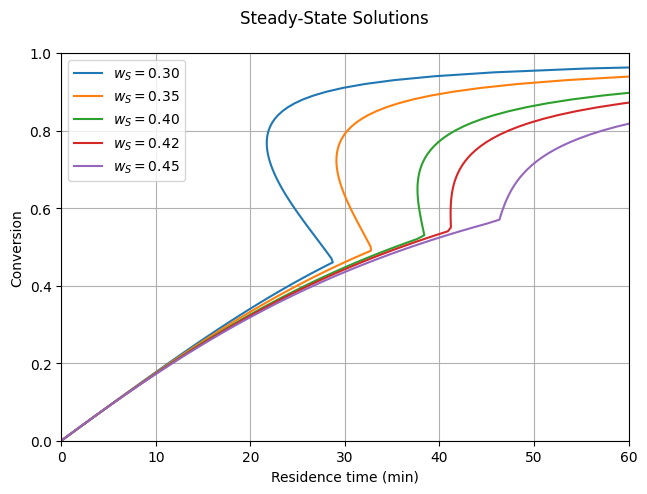

In [ ]:
fig2, ax = plt.subplots(1, 1)
fig2.suptitle("Steady-state solutions".title())
fig2.tight_layout()

T = 86.      # °C
Iin = 0.032  # mol/L
tau_max = 60*60.

X_M = np.linspace(0., 1., num=101)
tau = np.empty_like(X_M)
for w_S in [0.3, 0.35, 0.4, 0.42, 0.45]:
    tau_guess = 60.
    tau[:] = np.nan
    for i in range(X_M.size):
        tau[i] = solve_residence_time(X_M[i], w_S, Iin, T, params, tau_guess)
        tau_guess = tau[i]
        if tau[i] > tau_max:
            break
    notnan = ~np.isnan(tau)
    ax.plot(tau[notnan]/60, X_M[notnan], label=rf"$w_S={w_S:.2f}$")

ax.grid(True)
ax.legend(loc='best')
ax.set_ylabel("Conversion")
ax.set_ylim(0., 1.)
ax.set_xlim(0., tau_max/60)
ax.set_xlabel("Residence time (min)")

At this temperature, multiple steady states appear for solvent contents below approximately 42 wt%. Feel free to play with the reaction conditions.

## Questions/Extras

1. Describe what happens as the mean residence time is progressively increased from 0 to 60 minutes at 30 wt% solvent.
2. Describe what happens as the mean residence time is changed in the opposite direction.
3. What happens if the system is (magically) placed in the middle steady-state solution?